### Submission guidelines

1. Fill in your name in the notebook in the top cell.
2. Fill in the gaps in the code where indicated. <br> Make sure that you:<br> - fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" <br> - **do not leave any `raise NotImplementedErrors`** in the code
3. Do **NOT change the variable names**, however, you can add comments in the code.
4. Do **NOT remove any of the cells** of the notebook!
5. Discussion is allowed, but every student needs to hand a personal version of the lab. Plagiarism will be sanctioned!   
6. Before submitting, restart your kernel & **make sure that every cell runs**.<br>Code that doesn't run will not be scored.<br>The notebooks with all source code, and optional extra files need to be handed in using Ufora.<br> Make sure all your notebooks are already executed when you upload them (i.e. there should be output after the cells). 
7. **Zip** your lab assignment folder and name the archive: `Surname_Name.zip` <br> Keep the same folder structure as the provided lab assignment!<br><span style='color: red'>Do not rename any of the notebooks or files</span>!<br>



In [ ]:
NAME = "Cesar Zapata"


Final tip: make sure you have answered every question and filled in all the required code by running through the notebook and searching for *YOUR ANSWER HERE* and *YOUR CODE HERE*!

Good luck!

---

# Part 2: Data preparation
In Lab2 you saw how to extract data from the Mimic-III database with SQL commands. In this Lab we will use machine learning in to predict the mortality of patients in the ICU based on their vital signs of the first 48h spent in the ICU.

The raw data you've extracted in Lab2 cannot directly be used for machine learning. In order to do machine learning we need clean the structured data. This notebook will guide you through the steps of converting this raw data into a suitable dataset for machine learning.

**All the required packages for this lab are in the requirements.txt file, we can all install them with one pip command:**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

We have already extracted the raw dataset for you, so you don't need to run any SQL queries in order to obtain it. It is stored in a **.parquet** format, this is a compressed data format so that the dataset doesn't take too much space.

In [3]:
### Path to your 'icustays_events.parquet' file
path_to_data_file = 'data/icustays_events.parquet'

# Load data as a pandas DataFrame using the ICU stay ID as the DataFrame index, for facilitating data manipulation.
data = pd.read_parquet(path_to_data_file).set_index('icustay_id')

A quick preview of data can be obtained using the 'head' function, which prints the first rows of any given DataFrame:

In [4]:
data.head(5)

,hours_in_icu,sodium,glucose,urea,creatinine,bilirubin,albumin,hemoglobin,white_blood_cells,ph,...,mean_blood_pressure,respiratory_rate,oxygen_saturation,temperature,central_venous_pressure,systolic_blood_pressure,diastolic_blood_pressure,mortality_icu,age,gender
icustay_id,,,,,,,,,,,,,,,,,,,,,
200001,0.346667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,61.05,0
200001,10.496667,139.0,87.0,83.0,2.7,0.2,NaN,7.3,2.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,61.05,0
200001,16.013333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,61.05,0
200001,22.630000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,61.05,0
200001,23.830000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,61.05,0


We can take a look at all the columns that are in the dataset:

In [5]:
data.columns

Index(['hours_in_icu', 'sodium', 'glucose', 'urea', 'creatinine', 'bilirubin',
       'albumin', 'hemoglobin', 'white_blood_cells', 'ph', 'po2', 'pco2',
       'weight', 'glasgow_coma_scale', 'heart_rate', 'mean_blood_pressure',
       'respiratory_rate', 'oxygen_saturation', 'temperature',
       'central_venous_pressure', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'mortality_icu', 'age', 'gender'],
      dtype='object')

The dataset contains information about:
- patient demographics: age, gender, weight
- physiological vital signs: heart rate, mean blood pressure, respiratory rate, ...
- lab test results: sodium, glucose, urea, creatinin, ...
- Mortality in hospital and mortality at 90 days

Each observation/row is associated with a time stamp (column 'hours_in_icu'), indicating the number of hours since ICU admission where the observation was made. Each icustay has several observations for the same variable/column. The dataset contains the observations of the first **48h** in the ICU. 

We can print the number of ICU stays by calculating the length of the unique indexes, number of missing data using the 'info' function and summary statistics using the 'describe' function:

In [6]:
print('Number of ICU stays: ' + str(len(data.index.unique())))
print('Number of survivors: ' + str(len(data[data['mortality_icu']==0].index.unique())))
print('Number of non-survivors: ' + str(len(data[data['mortality_icu']==1].index.unique())))
print('Mortality: ' + str(round(100*len(data[data['mortality_icu']==1].index.unique()) / len(data.index.unique()),1)) + '%')
print()
display.display(data.info(null_counts=True))
display.display(data.describe())

Number of ICU stays: 60497
Number of survivors: 56245
Number of non-survivors: 4252
Mortality: 7.0%

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3508732 entries, 200001 to 299924
Data columns (total 25 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   hours_in_icu              3508732 non-null  float64
 1   sodium                    194211 non-null   float64
 2   glucose                   239380 non-null   float64
 3   urea                      161256 non-null   float64
 4   creatinine                161925 non-null   float64
 5   bilirubin                 44044 non-null    float64
 6   albumin                   24750 non-null    float64
 7   hemoglobin                189641 non-null   float64
 8   white_blood_cells         154006 non-null   float64
 9   ph                        207553 non-null   float64
 10  po2                       191904 non-null   float64
 11  pco2                      191886 non

C:\Users\cesar\AppData\Local\Temp\ipykernel_436\107955085.py:6: FutureWarning: null_counts is deprecated. Use show_counts instead
  display.display(data.info(null_counts=True))


None

,hours_in_icu,sodium,glucose,urea,creatinine,bilirubin,albumin,hemoglobin,white_blood_cells,ph,...,mean_blood_pressure,respiratory_rate,oxygen_saturation,temperature,central_venous_pressure,systolic_blood_pressure,diastolic_blood_pressure,mortality_icu,age,gender
count,3.508732e+06,194211.000000,239380.000000,161256.000000,161925.000000,44044.000000,24750.000000,189641.000000,154006.000000,207553.000000,...,2.389479e+06,2.749536e+06,2.696923e+06,663307.000000,634587.000000,1.346937e+06,1.345888e+06,3.508732e+06,3.508732e+06,3.508732e+06
mean,1.986780e+01,138.477486,138.304382,27.384032,1.530301,3.485353,2.964687,10.558108,12.054484,7.366756,...,7.811200e+01,2.189388e+01,9.743180e+01,36.739931,14.272348,1.191758e+02,6.141950e+01,9.192922e-02,7.050887e+01,5.625790e-01
std,1.375830e+01,5.248224,61.905269,22.554084,1.630141,5.586890,0.655737,2.142619,10.187143,0.086771,...,1.247662e+02,1.420597e+03,5.975244e+02,7.097582,31.452385,1.955656e+02,2.214669e+02,2.889261e-01,5.472241e+01,4.960685e-01
min,0.000000e+00,1.210000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.940000,...,-1.350000e+02,0.000000e+00,0.000000e+00,-73.270000,-41.000000,-2.000000e+00,-2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.645000e+00,136.000000,104.000000,13.000000,0.700000,0.500000,2.500000,9.200000,7.600000,7.320000,...,6.700000e+01,1.500000e+01,9.600000e+01,36.200000,8.000000,1.030000e+02,5.000000e+01,0.000000e+00,5.106000e+01,0.000000e+00
50%,1.798694e+01,138.000000,126.000000,20.000000,1.000000,1.200000,3.000000,10.300000,10.600000,7.380000,...,7.600000e+01,1.900000e+01,9.800000e+01,36.660000,11.000000,1.160000e+02,5.900000e+01,0.000000e+00,6.509000e+01,1.000000e+00
75%,3.096333e+01,141.000000,156.000000,34.000000,1.600000,4.500000,3.400000,11.700000,14.500000,7.420000,...,8.700000e+01,2.400000e+01,9.900000e+01,37.220000,15.000000,1.330000e+02,7.000000e+01,0.000000e+00,7.730000e+01,1.000000e+00
max,4.800000e+01,183.000000,2440.000000,270.000000,46.600000,82.200000,6.300000,108.000000,665.600000,7.930000,...,1.201300e+05,2.355555e+06,9.810230e+05,5335.580000,10263.000000,1.411460e+05,1.141090e+05,1.000000e+00,3.115600e+02,1.000000e+00


In [ ]:
# Feel free to use this cell to perform other exploratory operations, plots, etc.

The dataset consists of 52 799 unique ICU stays and 3 293 990 observations. From the Non-Null Count column we can see that all columns with the exception of 'hours', 'mortality', 'age' and gender have missing information. Looking at the maximum and minimum values it is possible to spot the presence of outliers (e.g. minimum pH of 0). Both missing data and outliers are very common in ICU databases and need to be taken into consideration before applying ML algorithms.

## Variable selection

There should be a trade-off between the potential value of the variable in the model and the amount of data available. We already saw the amount of missing data for every column, but we still do not know how much information is missing at the patient level. In order to do so, we are going to aggregate data by ICU stay and look at the number of non-null values, using the 'groupby' function together with the 'mean' operator. This will give an indication of how many ICU stays have at least one observation for each variable. 

We will consider every ICU stay as an independent sample. 

In [7]:
print(data.groupby(['icustay_id']).mean().info(show_counts=1))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60497 entries, 200001 to 299999
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   hours_in_icu              60497 non-null  float64
 1   sodium                    54704 non-null  float64
 2   glucose                   52304 non-null  float64
 3   urea                      52350 non-null  float64
 4   creatinine                52358 non-null  float64
 5   bilirubin                 25719 non-null  float64
 6   albumin                   17638 non-null  float64
 7   hemoglobin                56426 non-null  float64
 8   white_blood_cells         56370 non-null  float64
 9   ph                        33963 non-null  float64
 10  po2                       32452 non-null  float64
 11  pco2                      32449 non-null  float64
 12  weight                    40730 non-null  float64
 13  glasgow_coma_scale        28916 non-null  float64
 14  

- **Bilirubin**, **albumin** and **central_venous_pressure** will be discarded due to the high amount of missing data.
The other variables will be kept. Let us start with **time-variant** variables and set aside age and gender for now:

In [8]:
ts_variables = ['sodium', 'glucose', 'urea', 'creatinine', 'hemoglobin', 'white_blood_cells', 'ph', 'po2', 'pco2', 'weight', 'glasgow_coma_scale', 'heart_rate', 
               'mean_blood_pressure', 'respiratory_rate', 'oxygen_saturation', 'temperature', 'systolic_blood_pressure', 'diastolic_blood_pressure']
static_variables = ['age', 'gender']
label = ['mortality_icu']

## Removal of outliers

We can use boxplots to see the amount of outliers and how far they are.

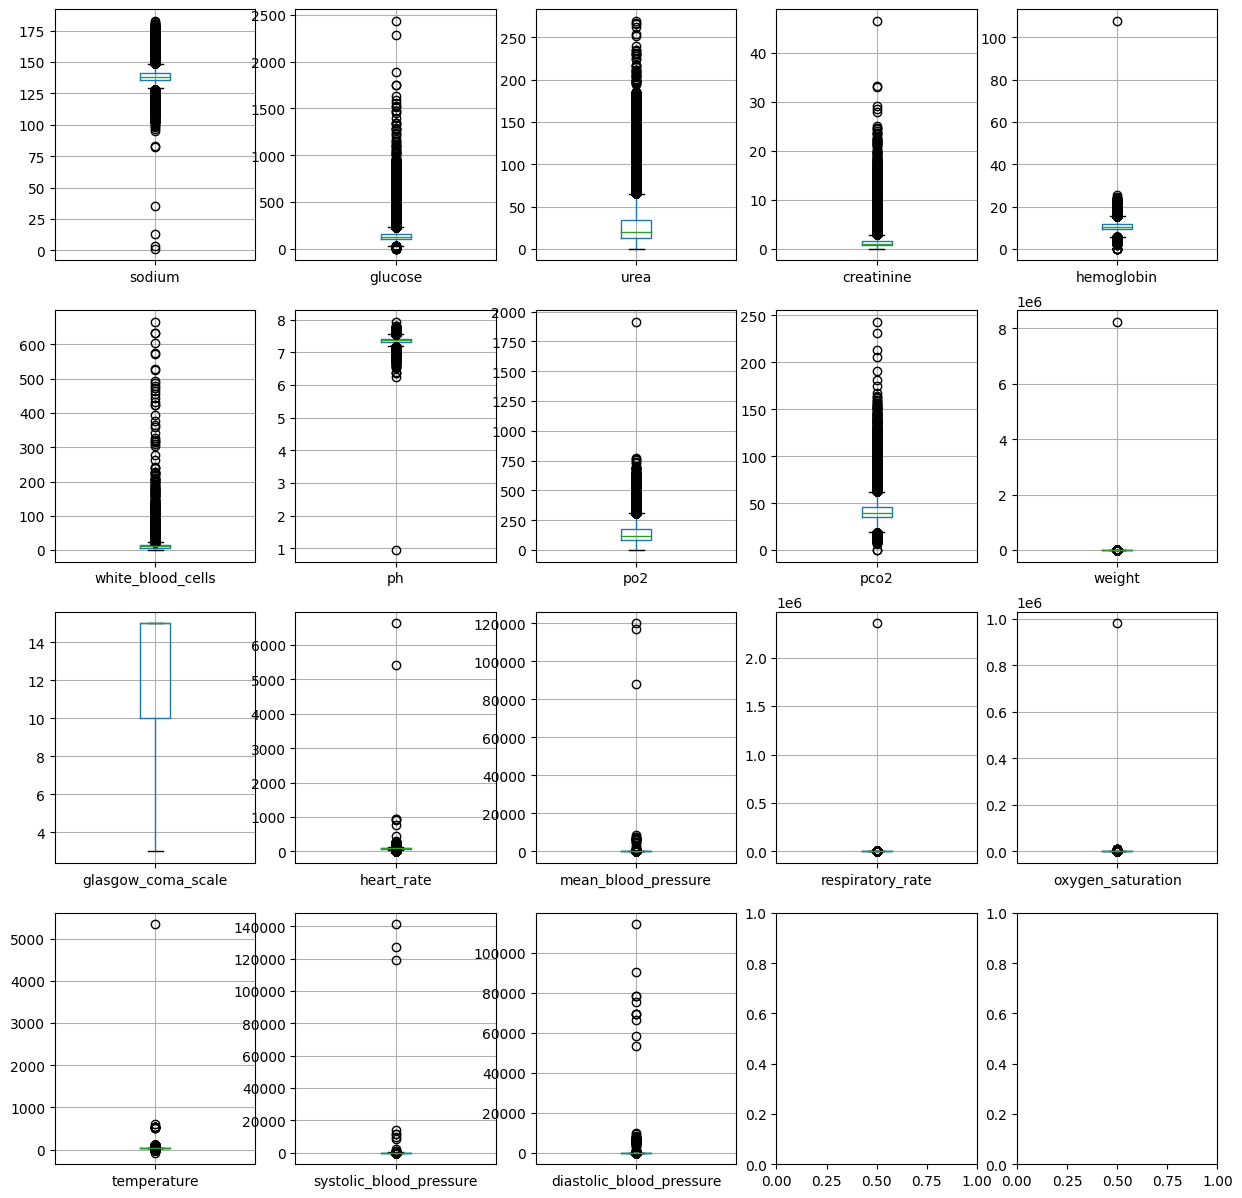

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(15, 15))

for idx, variable in enumerate(ts_variables):
    a = data.boxplot(variable, ax=axes.flatten()[idx])
    
plt.show()

In some cases, the outliers are so deviant from the norm that it is not even possible to visualize the distribution of data (minimum, first quartile, median, third quartile, maximum) using boxplots. A lot of outliers are unrealisticly high or low. Ideally, we want to remove values that probably wrong due to incorrect input or measurement (such as negative temperatures or a weight above 1000kg), but we want to keep extreme values that are related to the patients poor health condition. In order to choose good threshold values for outlier removal, ideally, expert knowledge is needed to avoid discarding useful information. In our case we choose the values that (according to the boxplots above) seem to be very extreme.

In [10]:
nulls_before = data.isnull().sum().sum()

data.loc[data['glucose']>2000, 'glucose'] = np.nan
data.loc[data['creatinine']>40, 'creatinine'] = np.nan
data.loc[data['hemoglobin']>40, 'hemoglobin'] = np.nan
data.loc[(data['ph']>7.8) | (data['ph']<6.8), 'ph'] = np.nan
data.loc[data['po2']>1000, 'po2'] = np.nan
data.loc[data['pco2']>1000, 'pco2'] = np.nan
data.loc[data['weight']>500, 'weight'] = np.nan
data.loc[data['heart_rate']>400, 'heart_rate'] = np.nan
data.loc[(data['mean_blood_pressure']>300) | (data['mean_blood_pressure']<0), 'mean_blood_pressure'] = np.nan
data.loc[data['respiratory_rate']>300, 'respiratory_rate'] = np.nan
data.loc[(data['oxygen_saturation']>100) | (data['oxygen_saturation']<0), 'oxygen_saturation'] = np.nan
data.loc[(data['temperature']>50) | (data['temperature']<20), 'temperature'] = np.nan
data.loc[data['systolic_blood_pressure']>300, 'systolic_blood_pressure'] = np.nan
data.loc[data['diastolic_blood_pressure']>300, 'diastolic_blood_pressure'] = np.nan
data.loc[data['age'] > 100, 'age'] = 91.4

nulls_now = data.isnull().sum().sum()
print('Number of observations removed: ' + str(nulls_now - nulls_before))
print('Observations corresponding to outliers: ' + str(round((nulls_now - nulls_before)*100/data.shape[0],2)) + '%')

Number of observations removed: 2256
Observations corresponding to outliers: 0.06%


The same code as before can be used to verify the data distribution after exclusion of outliers. Setting by = 'mortality_icu' shows the boxplots partitioned by outcome.

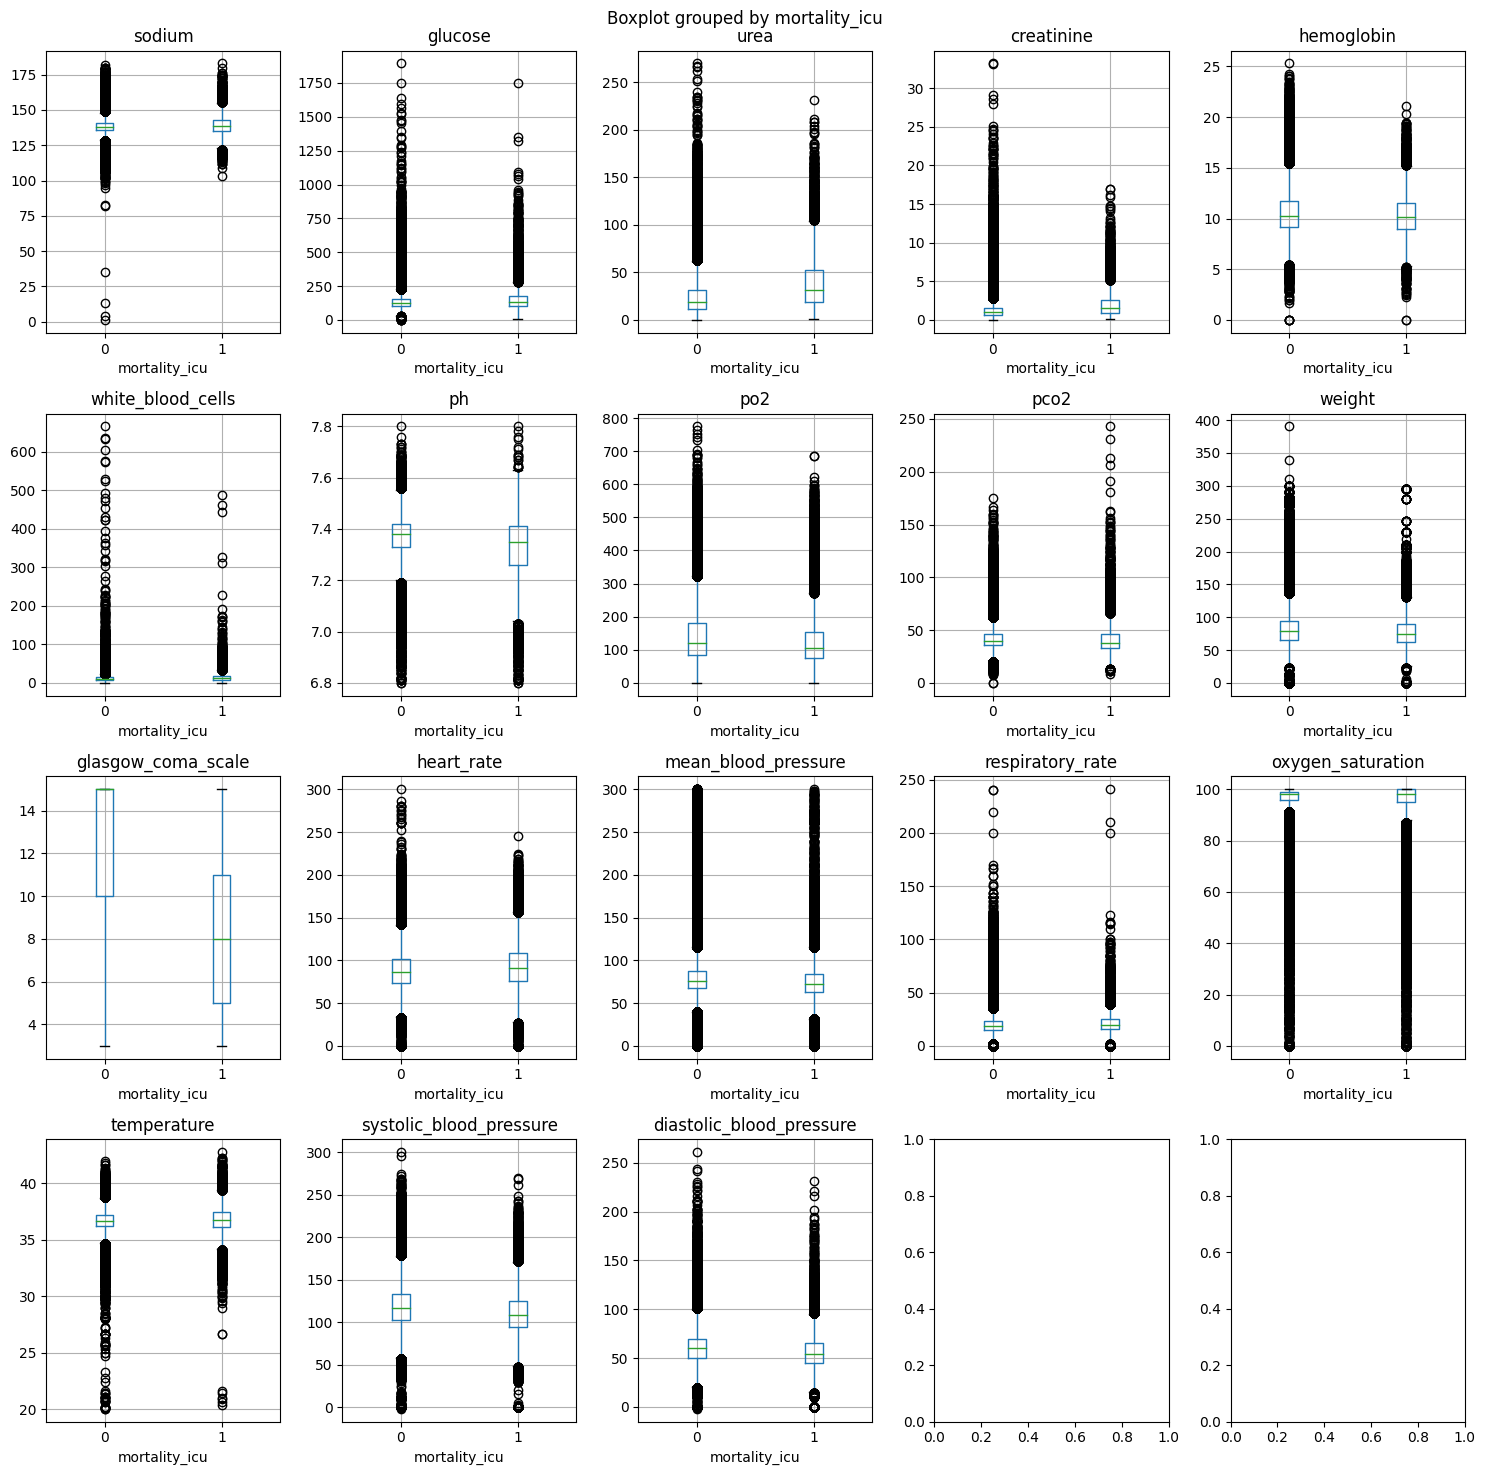

In [11]:
fig, axes = plt.subplots(4, 5, figsize=(15,15))

for idx, variable in enumerate(ts_variables):
    a = data.boxplot(variable, ax=axes.flatten()[idx], by='mortality_icu')

fig.tight_layout()
plt.show()

## Feature extraction

The next step before ML is to extract relevant features from the time series. We cannot simply use the time series data for our model as for every ICU stay the number of observations and the time at which they were taken are different. Moreover there a lot of observations in 48h at the ICU which would could lead to the overfitting of our models. There is a simpler solution, which is to use only a portion of the information available, ideally the most relevant information for the prediction task.

Feature construction addresses the problem of finding the transformation of variables containing the greatest amount of useful information. We will use four statistical features in order to construct/extract information from the time series:
- Maximum
- Minimum
- Standard deviation
- Mean

These features will summarize the worst, best, variation and average patient' condition from the first 48h the patient stayed in the ICU. Using the 'groupby' function to aggregate data by ICU stay, together with the 'max', 'min', 'std' and 'mean' operators, these features can be easily extracted.

In [12]:
ts_data_max = data.groupby(['icustay_id'])[ts_variables].max()
ts_data_max.columns = ['max_' + str(col) for col in ts_data_max.columns]

ts_data_min = data.groupby(['icustay_id'])[ts_variables].min()
ts_data_min.columns = ['min_' + str(col) for col in ts_data_min.columns]

ts_data_sd = data.groupby(['icustay_id'])[ts_variables].std()
ts_data_sd.columns = ['sd_' + str(col) for col in ts_data_sd.columns]

ts_data_mean = data.groupby(['icustay_id'])[ts_variables].mean()
ts_data_mean.columns = ['mean_' + str(col) for col in ts_data_mean.columns]

ts_features = pd.concat([ts_data_min, ts_data_max, ts_data_sd, ts_data_mean],axis=1)

# Dropping all the rows that contain nan's
ts_features = ts_features.dropna()

print('Extracted features: ')
display.display(list(ts_features.columns))
print('')
print('Number of rows with nan\'s dropped: ' + str(len(data.index.unique()) - ts_features.shape[0]))
print('Number of ICU stays: ' + str(ts_features.shape[0]))
print('Number of features: ' + str(ts_features.shape[1]))
ts_features.head()

Extracted features: 


['min_sodium',
 'min_glucose',
 'min_urea',
 'min_creatinine',
 'min_hemoglobin',
 'min_white_blood_cells',
 'min_ph',
 'min_po2',
 'min_pco2',
 'min_weight',
 'min_glasgow_coma_scale',
 'min_heart_rate',
 'min_mean_blood_pressure',
 'min_respiratory_rate',
 'min_oxygen_saturation',
 'min_temperature',
 'min_systolic_blood_pressure',
 'min_diastolic_blood_pressure',
 'max_sodium',
 'max_glucose',
 'max_urea',
 'max_creatinine',
 'max_hemoglobin',
 'max_white_blood_cells',
 'max_ph',
 'max_po2',
 'max_pco2',
 'max_weight',
 'max_glasgow_coma_scale',
 'max_heart_rate',
 'max_mean_blood_pressure',
 'max_respiratory_rate',
 'max_oxygen_saturation',
 'max_temperature',
 'max_systolic_blood_pressure',
 'max_diastolic_blood_pressure',
 'sd_sodium',
 'sd_glucose',
 'sd_urea',
 'sd_creatinine',
 'sd_hemoglobin',
 'sd_white_blood_cells',
 'sd_ph',
 'sd_po2',
 'sd_pco2',
 'sd_weight',
 'sd_glasgow_coma_scale',
 'sd_heart_rate',
 'sd_mean_blood_pressure',
 'sd_respiratory_rate',
 'sd_oxygen_satura


Number of rows with nan's dropped: 53434
Number of ICU stays: 7063
Number of features: 72


,min_sodium,min_glucose,min_urea,min_creatinine,min_hemoglobin,min_white_blood_cells,min_ph,min_po2,min_pco2,min_weight,...,mean_pco2,mean_weight,mean_glasgow_coma_scale,mean_heart_rate,mean_mean_blood_pressure,mean_respiratory_rate,mean_oxygen_saturation,mean_temperature,mean_systolic_blood_pressure,mean_diastolic_blood_pressure
icustay_id,,,,,,,,,,,,,,,,,,,,,
200003,141.0,90.0,19.0,0.7,10.4,35.0,7.36,74.0,33.0,78.0,...,39.100000,78.000000,10.142857,91.564103,75.259740,24.487013,96.662651,37.487895,98.142857,62.535714
200025,135.0,74.0,16.0,0.8,8.8,10.6,7.30,93.0,38.0,140.0,...,43.166667,142.949153,13.583333,100.868852,75.700000,19.861538,98.236364,37.553333,112.562500,53.812500
200030,136.0,98.0,23.0,0.9,9.1,12.9,7.37,90.0,28.0,114.0,...,29.666667,114.500000,14.785714,107.232143,84.562500,22.872727,95.053571,36.808947,117.263158,57.631579
200039,128.0,155.0,5.0,0.5,7.8,12.2,7.40,141.0,33.0,73.0,...,35.750000,73.000000,13.076923,100.888889,72.485507,19.672131,98.753846,37.575714,131.150000,43.550000
200045,144.0,18.0,14.0,0.7,10.2,15.4,7.19,56.0,35.0,50.0,...,41.571429,50.000000,12.000000,87.083333,75.354167,22.406250,97.571429,36.658889,126.406250,47.125000


We still have to add our non time variant features and labels to the dataset:

In [13]:
static_features = data[static_variables].groupby(by='icustay_id').mean()
mortality = data[['mortality_icu']].groupby(by='icustay_id').mean()

all_features = pd.concat([ts_features, static_features, mortality], axis=1).dropna()
print('Number of ICU stays: ' + str(all_features.shape[0]))

Number of ICU stays: 7063


Now we can save this cleaned dataset in order to use it for the machine learning part of this Lab.

In [14]:
all_features.to_parquet('cleaned_dataset.parquet')

Continue with the notebook called **Part 3 - Mortality Clustering and Classification.ipynb**.